In [1]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../src')


import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.preprocess import extend_market_data

# Define ticker symbols for corn and ethanol futures
corn_ticker = "ZC=F"   # Corn Futures (CBOT)
ethanol_ticker = "ZS=F"  # Ethanol Futures (NYMEX)
corn = yf.Ticker(corn_ticker)
ethanol = yf.Ticker(ethanol_ticker)
corn_data = corn.history(start ="2014-01-01", end ="2024-12-31")
ethanol_data = ethanol.history(start ="2014-01-01", end ="2024-12-31")

corn_data = extend_market_data(corn_data)
ethanol_data = extend_market_data(ethanol_data)

features = list(corn_data.columns)
features.remove('expiry')
corn_data = corn_data[features]

features = list(ethanol_data.columns)
features.remove('expiry')
ethanol_data = ethanol_data[features]



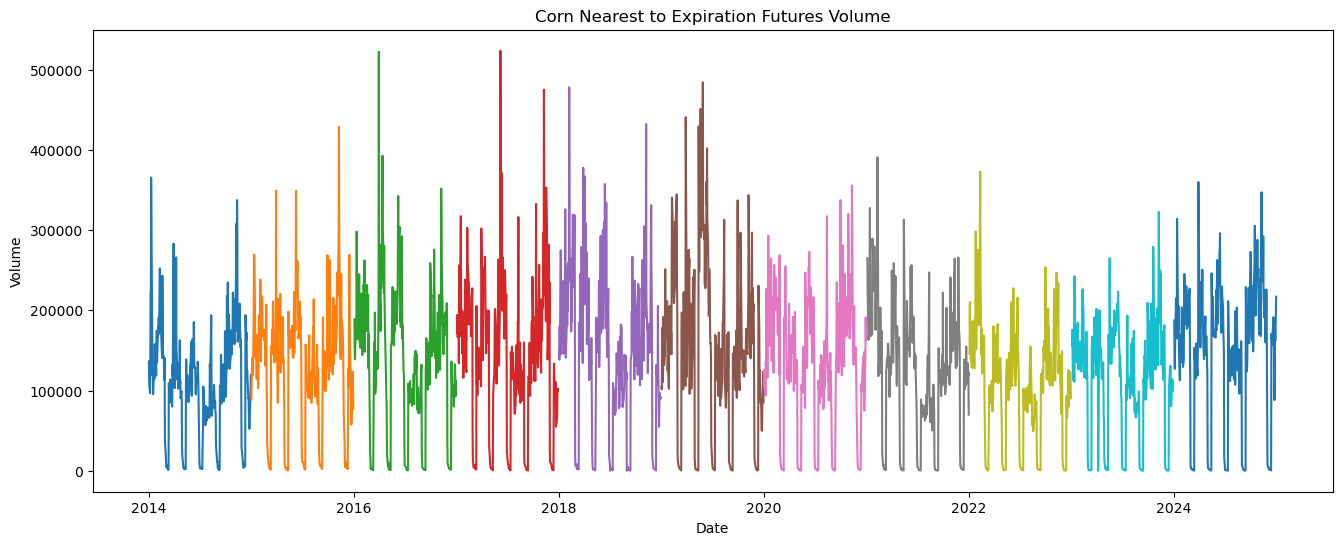

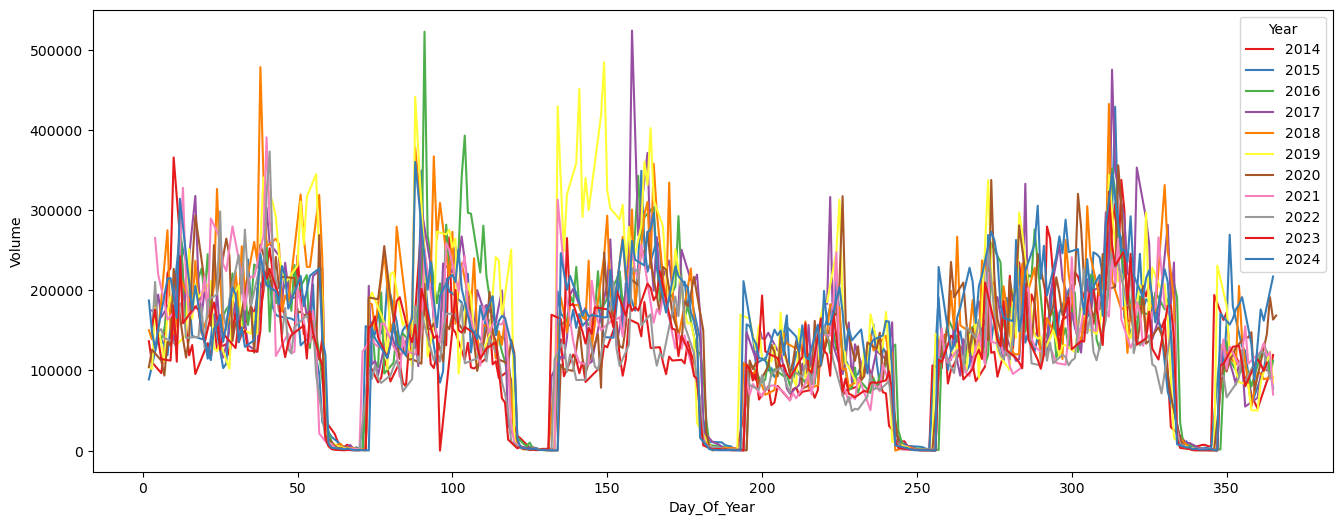

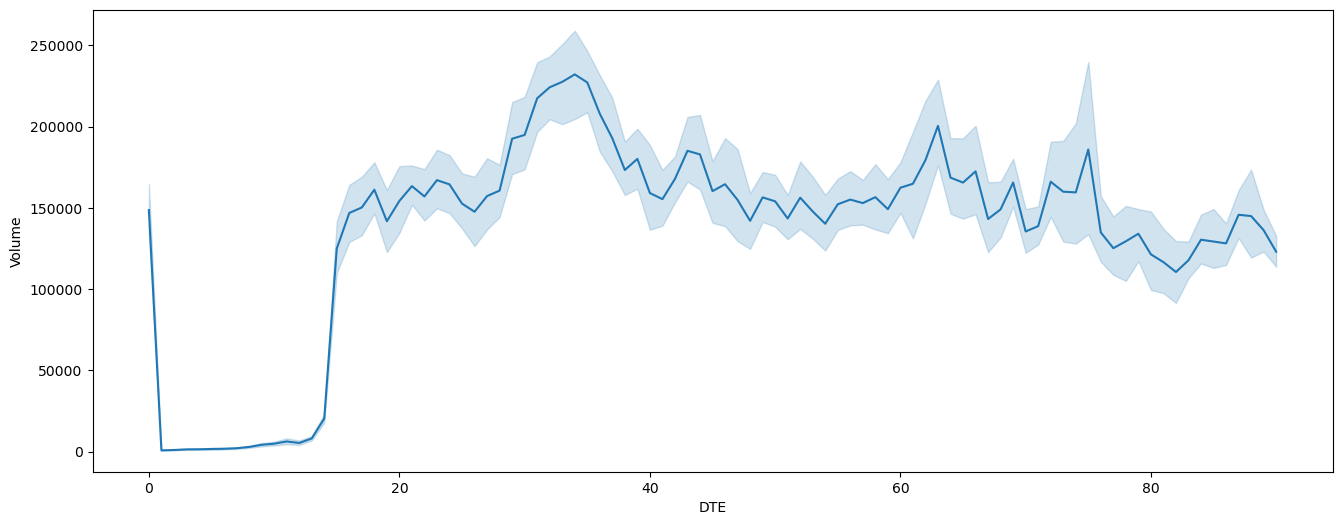

In [2]:
plt.figure(figsize = (16,6))
plt.title("Corn Nearest to Expiration Futures Volume")
for year in corn_data['Year'].unique():  # Loop through each unique year
    yearly_data = corn_data[corn_data['Year'] == year]
    sns.lineplot(x = 'Date', y = 'Volume', data = yearly_data)
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Day_Of_Year', y = 'Volume', data = corn_data, hue ='Year', palette='Set1')
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'DTE', y = 'Volume', data = corn_data)
plt.show()

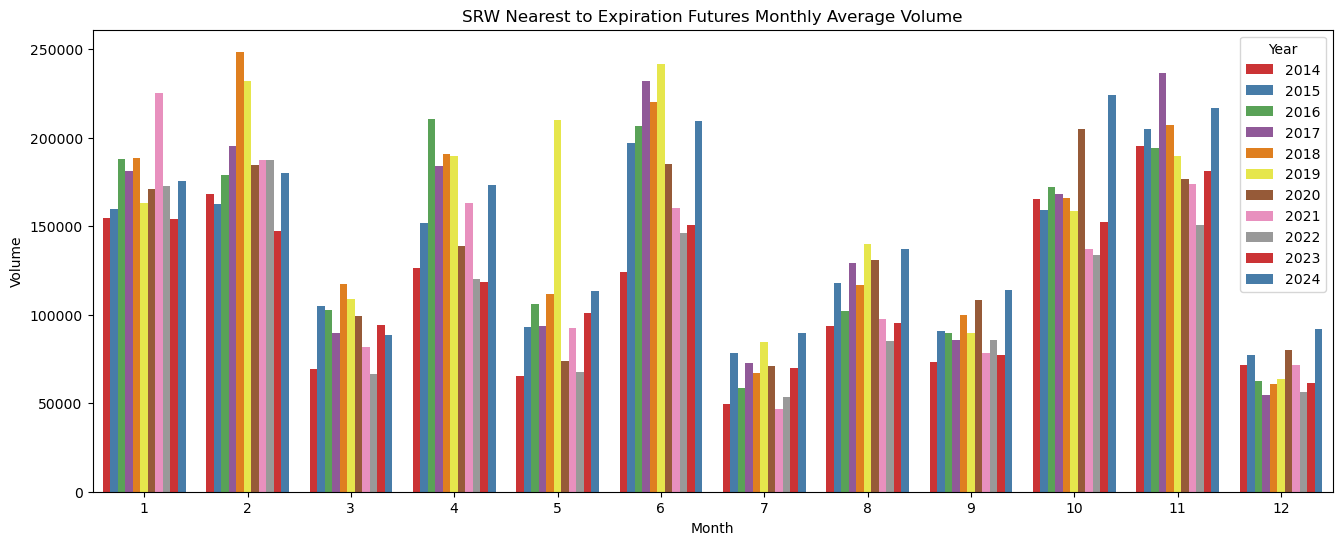

In [3]:
monthly_average = corn_data.groupby(['Year', 'Month']).Volume.agg('mean').reset_index()

plt.figure(figsize = (16,6))
plt.title("SRW Nearest to Expiration Futures Monthly Average Volume")
sns.barplot(x = 'Month', y = 'Volume', data = monthly_average, hue = 'Year', palette='Set1')
# sns.barplot(x = 'Month', y = 'Volume', data = monthly_average)
plt.show()

The trading volume in March, May, July, September, and December are low, which is expected as these are the expiration dates of corn futures. However, August trading volume is also low, relative to the other months. 

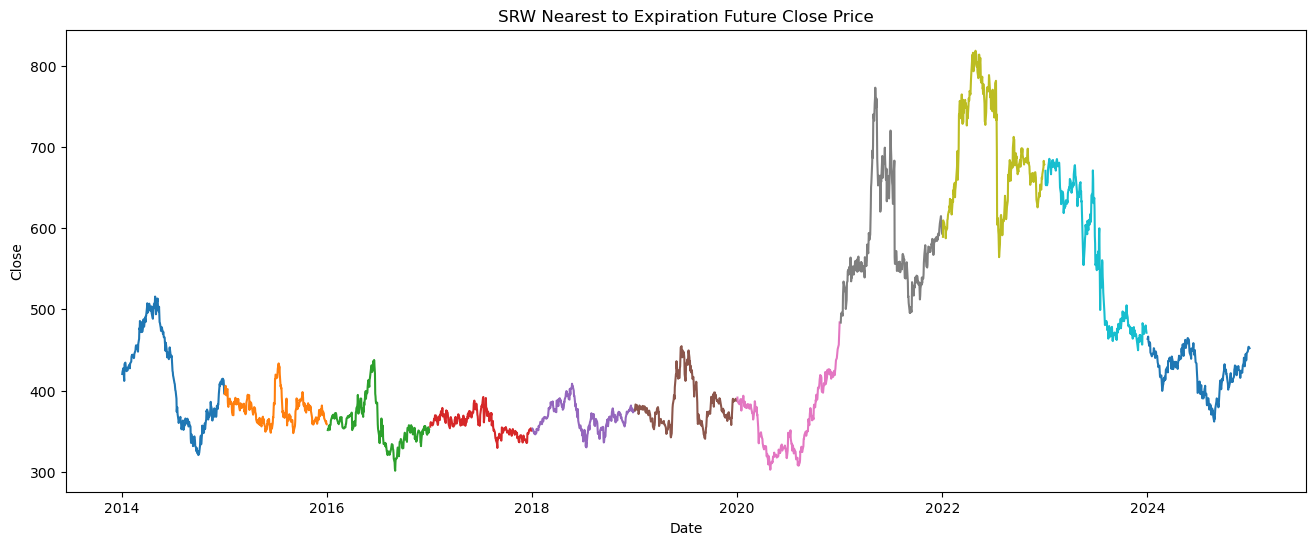

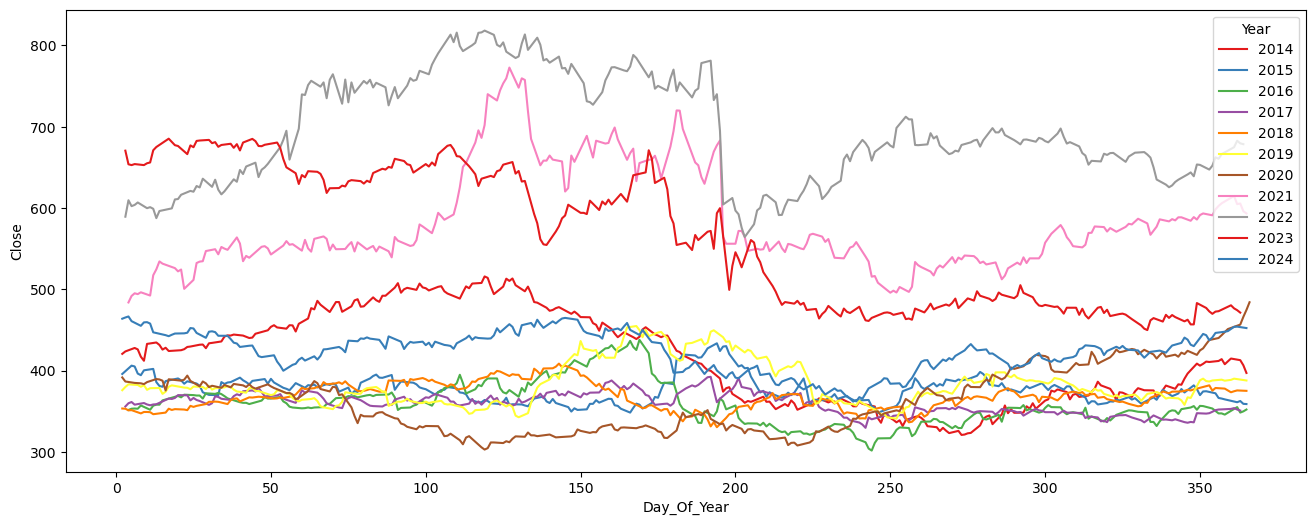

In [4]:
plt.figure(figsize = (16,6))
plt.title("SRW Nearest to Expiration Future Close Price")
for year in corn_data['Year'].unique():  # Loop through each unique year
    yearly_data = corn_data[corn_data['Year'] == year]
    sns.lineplot(x = 'Date', y = 'Close', data = yearly_data)
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Day_Of_Year', y = 'Close', data = corn_data, hue ='Year', palette='Set1')
plt.show()

count    2762.000000
mean        0.000026
std         0.016184
min        -0.190997
25%        -0.008552
50%         0.000000
75%         0.008789
max         0.077178
Name: Log_Return, dtype: float64


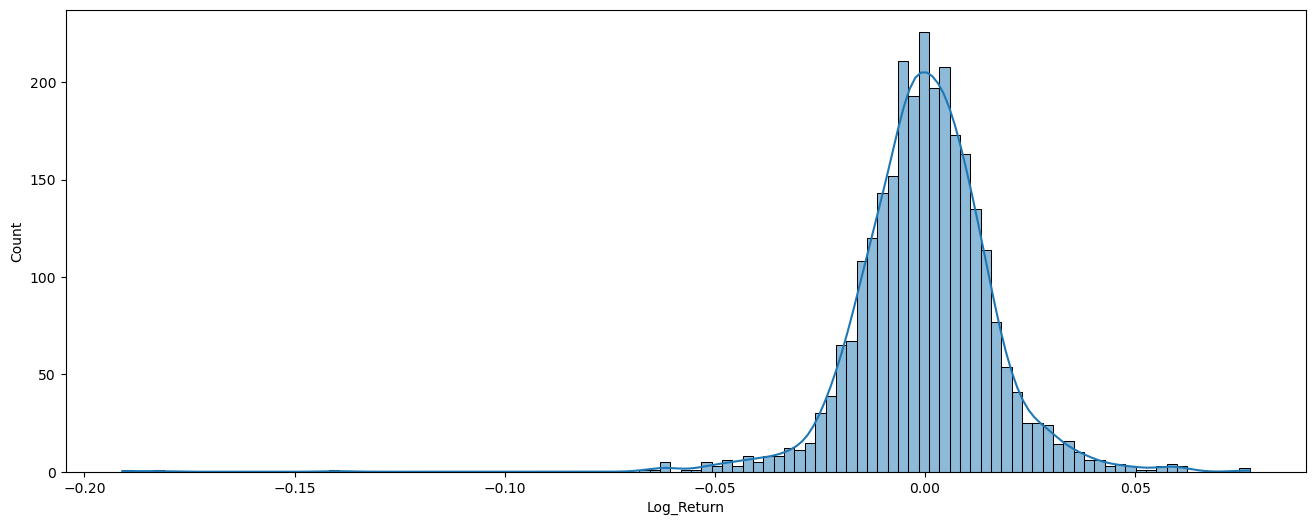

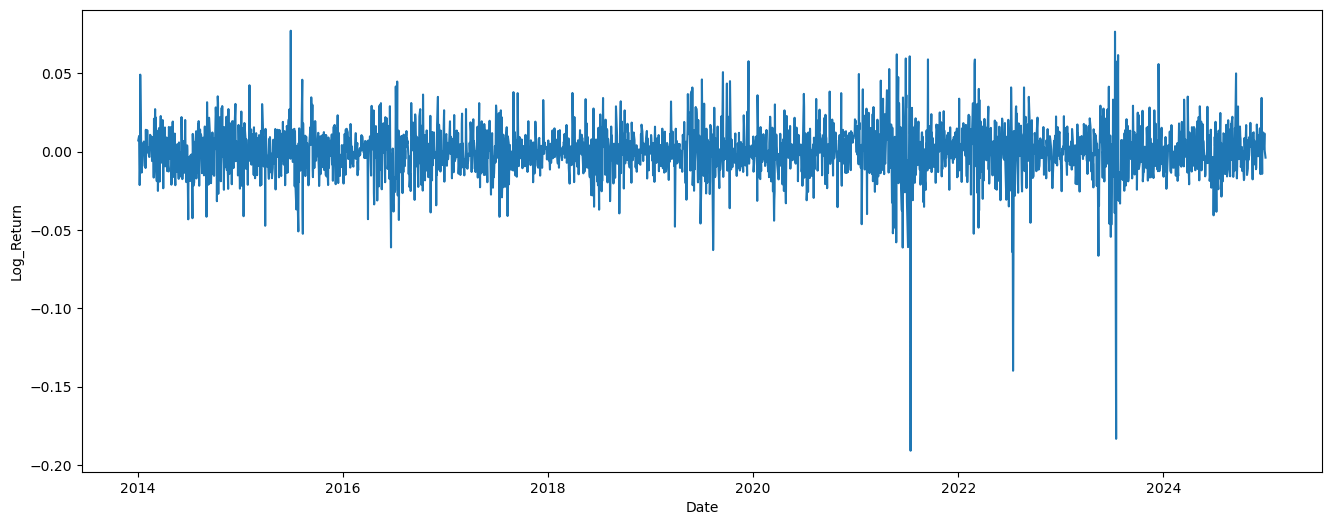

In [5]:
plt.figure(figsize = (16,6))
sns.histplot(corn_data['Log_Return'], kde = True)
print(corn_data['Log_Return'].describe())
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(corn_data['Log_Return'])
plt.show()

There's tiny seasonality at around 250 days.

C:\Users\johng23\AppData\Local\Temp\ipykernel_1720\2532573388.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / frequencies, power)


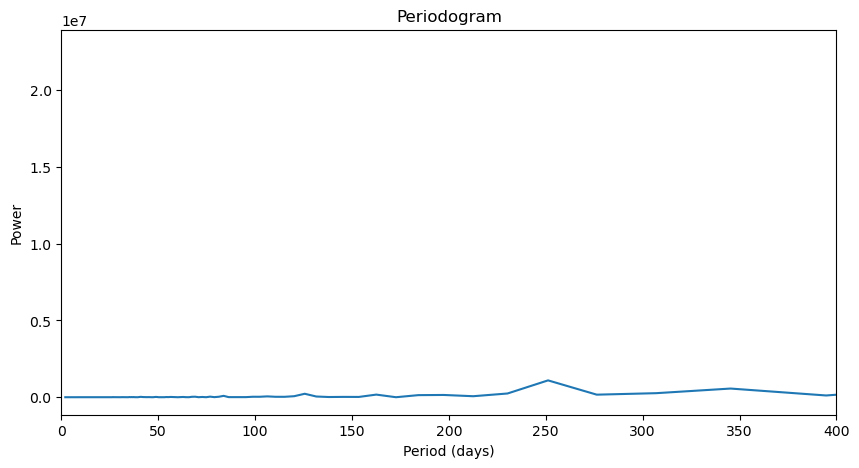

In [6]:
from scipy.signal import periodogram

frequencies, power = periodogram(corn_data['Close'].dropna())

plt.figure(figsize=(10, 5))
plt.plot(1 / frequencies, power)
plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.title("Periodogram")
plt.xlim(0, 400)  # Limit x-axis to reasonable periods
plt.show()

In [7]:
from src.data import DataLoader
dl = DataLoader()

production_raw = dl.get_production_data("CORN", 2014, national_level=True, raw=True)
production_national = production_raw[
    (production_raw.unit_desc == 'BU')
    & (production_raw.short_desc == 'CORN, GRAIN - PRODUCTION, MEASURED IN BU')
    & (production_raw.domain_desc == 'TOTAL')
    & (production_raw.reference_period_desc == 'YEAR')
][['state_name', 'Value', 'unit_desc', 'year', 'reference_period_desc', 'source_desc', 'short_desc']]

production_national['year'] = pd.to_numeric(production_national['year'])
production_national['Value'] = production_national['Value'].str.replace(',', '', regex=True)
production_national['Value'] = pd.to_numeric(production_national['Value'], errors='coerce')

stocks_national_raw = dl.get_stocks_data('CORN', 2014, True)
stocks_national_raw['end_month'] = stocks_national_raw['end_month'].astype(int)
stocks_national = stocks_national_raw[['year', 'end_month', 'CORN, GRAIN - STOCKS, MEASURED IN BU',
       'CORN, OFF FARM, GRAIN - STOCKS, MEASURED IN BU',
       'CORN, ON FARM, GRAIN - STOCKS, MEASURED IN BU']]
stocks_national = stocks_national.rename(columns={
    'CORN, GRAIN - STOCKS, MEASURED IN BU': 'Total',
    'CORN, ON FARM, GRAIN - STOCKS, MEASURED IN BU': 'ON_FARM',
    'CORN, OFF FARM, GRAIN - STOCKS, MEASURED IN BU': 'OFF_FARM',
})

C:\Users\johng23\AppData\Local\Temp\ipykernel_1720\807444305.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_years)


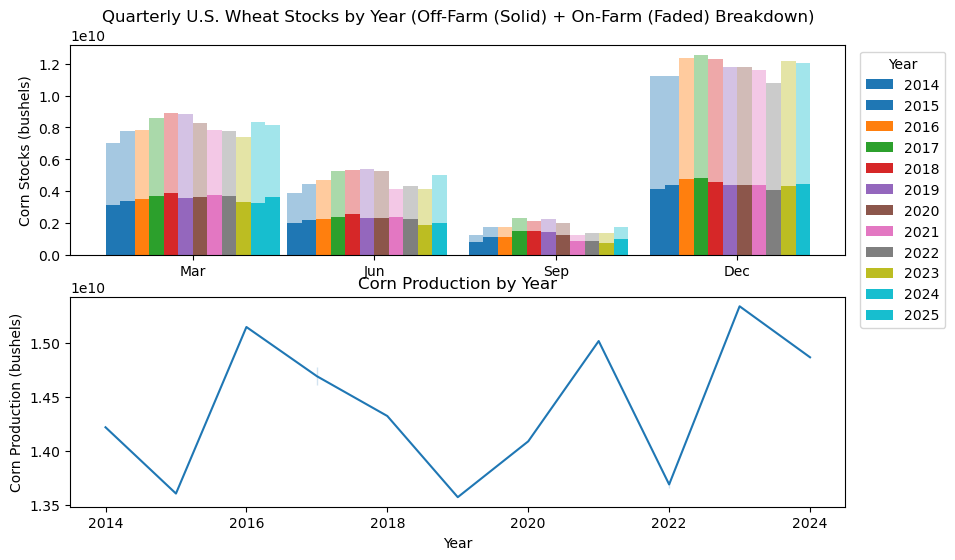

In [8]:
import matplotlib.cm as cm

month_map = {3: "Mar", 6: "Jun", 9: "Sep", 12: "Dec"}
stocks_national['month'] = stocks_national['end_month'].map(month_map)
months = ['Mar', 'Jun', 'Sep', 'Dec']
stocks_national['month'] = pd.Categorical(stocks_national['month'], categories=months, ordered=True)
stocks_national = stocks_national.sort_values(['month', 'year'])
years = sorted(stocks_national['year'].unique())
num_years = len(years)
bar_width = 0.08
positions = np.arange(len(months))

# Generate color map for each year
colors = cm.get_cmap('tab10', num_years)

fig, axes = plt.subplots(nrows=2, figsize=(10, 6))

ax=axes[0]
for i, year in enumerate(years):
    df_year = stocks_national[stocks_national['year'] == year]

    # Only include months that actually exist in this year's data
    valid_months = df_year['month'].tolist()
    month_indices = [months.index(m) for m in valid_months]

    offset = (i - num_years/2) * bar_width + bar_width/2
    x = np.array(month_indices) + offset

    # Fetch corresponding values in order
    on_farm_vals = df_year['ON_FARM'].values
    off_farm_vals = df_year['OFF_FARM'].values

    # Plot stacked bars
    ax.bar(x, off_farm_vals, width=bar_width, color=colors(i), label=f'{year}')
    ax.bar(x, on_farm_vals, width=bar_width, bottom=off_farm_vals, color=colors(i), alpha=0.4)

ax.set_xticks(positions)
ax.set_xticklabels(months)
# ax.set_xlabel("Month")
ax.set_ylabel("Corn Stocks (bushels)")
ax.set_title("Quarterly U.S. Wheat Stocks by Year (Off-Farm (Solid) + On-Farm (Faded) Breakdown)")
ax.legend(title="Year", bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 6))


sns.lineplot(x='year', y='Value', data=production_national, ax=axes[1])
axes[1].set_title("Corn Production by Year")
axes[1].set_ylabel("Corn Production (bushels)")
axes[1].set_xlabel("Year")

plt.savefig('../imgs/corn/production_stock.png')
plt.show()

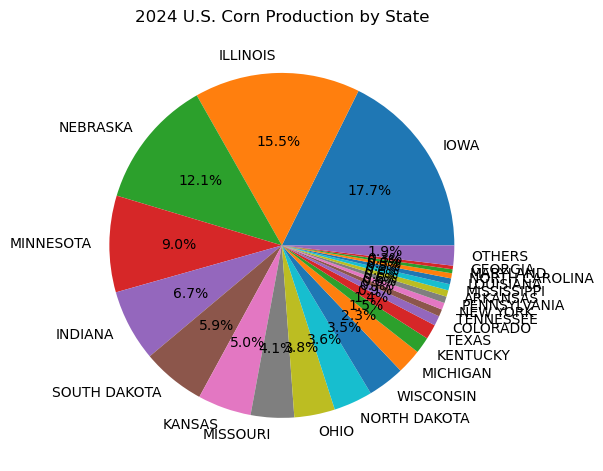

In [9]:
production_state_raw = dl.get_production_data("CORN", 2014, national_level=False, raw=True)

year = 2024
production_state = production_state_raw[
    (production_state_raw.unit_desc.isin(['BU', 'PCT BY TYPE'])) &
    (production_state_raw.reference_period_desc == 'YEAR') &
    (production_state_raw.year == year)
][['state_alpha', 'state_name', 'Value', 'unit_desc']]

production_state['Value'] = production_state['Value'].str.replace(',', '', regex=True)
production_state['Value'] = pd.to_numeric(production_state['Value'], errors='coerce')


fig, axes = plt.subplots(ncols=1, figsize=(10, 5.6))

# ploting the production for winter wheat by state
ax = axes

winter_production_state = production_state.sort_values('Value', ascending=False)
threshold = 48000000
major = winter_production_state[winter_production_state['Value'] >= threshold]
other = winter_production_state[winter_production_state['Value'] < threshold]
other_sum = other.Value.sum()

df_pie = pd.concat([
    major[['state_name', 'Value']],
    pd.DataFrame({'state_name': ['OTHERS'], 'Value': [other_sum]})
])

ax.set_title(f"{year} U.S. Corn Production by State")
ax.pie(df_pie.Value, labels=df_pie.state_name, autopct='%1.1f%%')

plt.show()

In [14]:
condition_state_raw = pd.concat(dl.get_condition_data('CORN', 2014, exact_year = year, national_level=False, raw=True) for year in range(2014,2026))


           util_practice_desc reference_period_desc   class_desc end_code  \
0   ALL UTILIZATION PRACTICES              WEEK #17  ALL CLASSES       17   
1   ALL UTILIZATION PRACTICES              WEEK #18  ALL CLASSES       18   
2   ALL UTILIZATION PRACTICES              WEEK #19  ALL CLASSES       19   
3   ALL UTILIZATION PRACTICES              WEEK #20  ALL CLASSES       20   
4   ALL UTILIZATION PRACTICES              WEEK #21  ALL CLASSES       21   
..                        ...                   ...          ...      ...   
5   ALL UTILIZATION PRACTICES              WEEK #10  ALL CLASSES       10   
6   ALL UTILIZATION PRACTICES              WEEK #15  ALL CLASSES       15   
7   ALL UTILIZATION PRACTICES              WEEK #10  ALL CLASSES       10   
8   ALL UTILIZATION PRACTICES              WEEK #15  ALL CLASSES       15   
9   ALL UTILIZATION PRACTICES              WEEK #10  ALL CLASSES       10   

   country_code CV (%) watershed_code state_alpha  year county_code  ...  \

In [18]:
print(condition_state_raw.columns)

Index(['util_practice_desc', 'reference_period_desc', 'class_desc', 'end_code',
       'country_code', 'CV (%)', 'watershed_code', 'state_alpha', 'year',
       'county_code', 'begin_code', 'source_desc', 'statisticcat_desc',
       'state_ansi', 'county_name', 'short_desc', 'region_desc',
       'domaincat_desc', 'domain_desc', 'sector_desc', 'prodn_practice_desc',
       'unit_desc', 'load_time', 'state_fips_code', 'county_ansi',
       'congr_district_code', 'commodity_desc', 'watershed_desc', 'zip_5',
       'agg_level_desc', 'country_name', 'group_desc', 'Value',
       'location_desc', 'week_ending', 'asd_desc', 'asd_code', 'state_name',
       'freq_desc'],
      dtype='object')


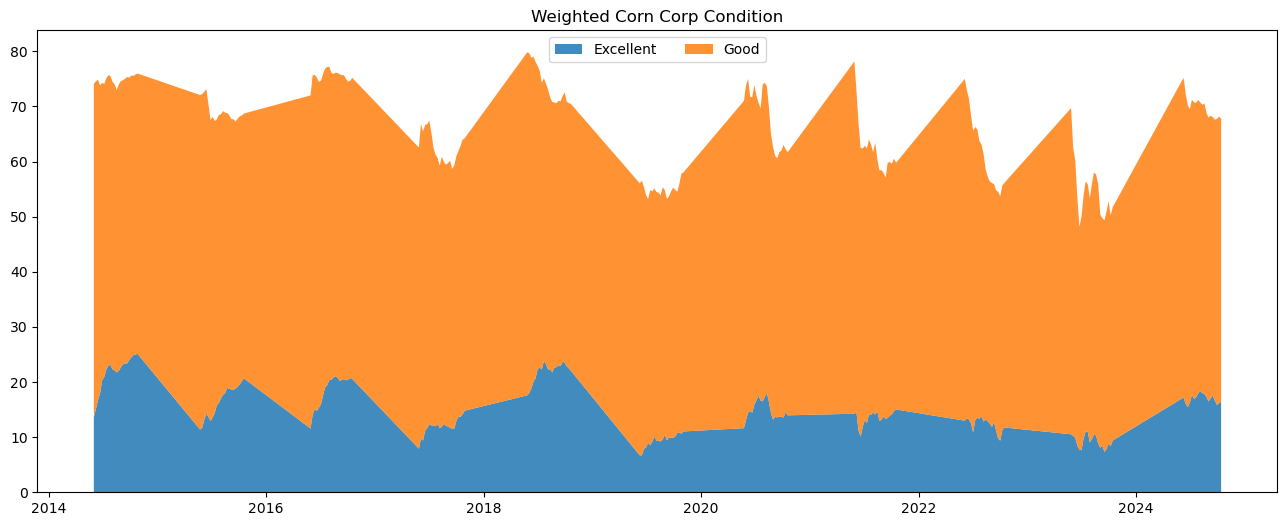

The correlation between the crop condition change and the next day price increment is 0.0541
The correlation between the crop condition change and the next 3 day price increment is -0.0149
The correlation between the crop condition change and the next 7 day price increment is 0.0241


In [25]:
SRW_states_of_interest = winter_production_state[:9][['state_name', 'Value']]
SRW_states_of_interest['weight'] = SRW_states_of_interest['Value'] / SRW_states_of_interest['Value'].sum()

condition_state_raw['year'] = pd.to_numeric(condition_state_raw['year'])
condition_state_raw['Value'] = pd.to_numeric(condition_state_raw['Value'], errors='coerce')
raw_data = condition_state_raw[
    (condition_state_raw.state_name.isin(SRW_states_of_interest['state_name']))
]
condition_state = raw_data.pivot(index=['week_ending', 'year', 'state_name', 'end_code'], columns='unit_desc', values='Value').reset_index()
condition_state.rename(columns={'end_code': 'week_number', 'week_ending': 'date'}, inplace=True)
condition_state.date = pd.to_datetime(condition_state.date)

# 1. Filter only SRW states
condition_srw = condition_state[condition_state['state_name'].isin(SRW_states_of_interest['state_name'])]

# 2. Merge weights into condition data
condition_srw = condition_srw.merge(SRW_states_of_interest, on='state_name', how='left')

# 3. Compute weighted condition percentages
conditions = ['PCT EXCELLENT', 'PCT GOOD', 'PCT FAIR', 'PCT POOR', 'PCT VERY POOR']
for col in conditions:
    condition_srw[col] = pd.to_numeric(condition_srw[col], errors='coerce')
    condition_srw[f'{col}_weighted'] = condition_srw[col] * condition_srw['weight']

# 4. Aggregate weekly by year
weekly_national = (
    condition_srw
    .groupby(['date'])[[f'{c}_weighted' for c in conditions]]
    .sum()
    .reset_index()
)

weekly_national['sum'] = (
    weekly_national['PCT EXCELLENT_weighted'] +
    weekly_national['PCT GOOD_weighted'] +
    weekly_national['PCT FAIR_weighted'] +
    weekly_national['PCT POOR_weighted'] +
    weekly_national['PCT VERY POOR_weighted']
)

df = weekly_national[weekly_national['sum']>=80].copy()
for condition in conditions:
    df[f'{condition}_weighted'] = df[f'{condition}_weighted'] * 100 / df['sum']

plt.figure(figsize=(16,6))
plt.stackplot(
    df['date'],
    [df[f'{col}_weighted'] for col in ['PCT EXCELLENT', 'PCT GOOD']],
    labels=['Excellent', 'Good'],
    alpha=0.85
)
plt.title(f"Weighted Corn Corp Condition")
plt.legend(loc='upper center', ncol=2)
# plt.savefig('../imgs/wheat/condition.png')
plt.show()

df['Good'] = df['PCT EXCELLENT_weighted'] + df['PCT GOOD_weighted']
df.rename(columns={'date': 'Date'}, inplace=True)
merged = pd.merge(df, corn_data, how='outer', on='Date')
merged.sort_values('Date', inplace=True)
merged.ffill(inplace=True)
merged['next_day_increment'] = merged['Close'].shift(-1) - merged['Close']
merged['next_3day_increment'] = merged['Close'].shift(-3) - merged['Close']
merged['next_7day_increment'] = merged['Close'].shift(-7) - merged['Close']
data = merged[merged.Date.isin(df.Date)][['Date', 'Good', 'Close', 'next_day_increment', 'next_3day_increment', 'next_7day_increment']].dropna()
data['condition_increment'] = data['Good']-data['Good'].shift(1)
print(f"The correlation between the crop condition change and the next day price increment is {(data.condition_increment).corr(data.next_day_increment):.4f}")
print(f"The correlation between the crop condition change and the next 3 day price increment is {(data.condition_increment).corr(data.next_3day_increment):.4f}")
print(f"The correlation between the crop condition change and the next 7 day price increment is {(data.condition_increment).corr(data.next_7day_increment):.4f}")

In [26]:


# # corn_data["Scaled Close"] = corn_scaler.fit_transform(corn_data["Close"].to_frame())
# # ethanol_data["Scaled Close"] = ethanol_scaler.fit_transform(ethanol_data["Close"].to_frame())


# plt.figure(figsize=(16, 6))
# plt.title("Comparison between the price of corn and ethanol Futures")
# sns.lineplot(x = 'Date', y = 'Scaled Close', data = corn_data, label = "corn")
# sns.lineplot(x = 'Date', y = 'Scaled Close', data = ethanol_data, label = "ethanol")
# plt.show()

# plt.figure(figsize=(16, 6))
# plt.title("Comparison between the volume of corn and ethanol Futures")
# sns.lineplot(x = 'Date', y = 'Scaled Volume', data = corn_data, label = "corn")
# sns.lineplot(x = 'Date', y = 'Scaled Volume', data = ethanol_data, label = "ethanol")
# plt.show()

In [27]:
# import sys
# sys.path.insert(0, '..')
# import src.data.weather_script as ws
# m = 200
# cropValue = 1
# BAP = ws.bigArrayParser("../data/2023_30m_cdls.tif", m, cropValue)


In [28]:
# k = 10
# r = 7
# cadot = BAP.get_area_with_climate(k, r, m, ["IA", "IL", "IN", "MO", "SD", "KS", "MN"], "2014-01-01", "2024-12-31")

In [29]:
if merged.index.name != 'Date':
    merged = merged.set_index('Date')
merged = merged.drop(columns = ["next_day_increment", "next_3day_increment", "next_7day_increment"])

In [30]:
corn_data["Log_Return_Shift"] = corn_data["Log_Return"].shift(-1)

from datetime import datetime
# start_date2231 = datetime.fromisoformat("2014-01-02")
import shelve
with shelve.open('feat_dict.db') as features:

    # Convert your features dict to a DataFrame
    features_df = pd.DataFrame.from_dict(features, orient='index')
    features_df.index = pd.to_datetime(features_df.index)
    def create_shifted_features(features_df, lags):
        shifted_dfs = []
        for lag in lags:
            shifted = features_df.shift(lag)
            shifted.columns = [f"{col}_lag_{lag}" for col in features_df.columns]
            shifted_dfs.append(shifted)
    
        # Concatenate all lagged features side-by-side
        return pd.concat(shifted_dfs, axis=1)

    lags = [2**i for i in range(1)]
    lagged_features = create_shifted_features(features_df, lags)
    # print(lagged_features.columns)
    features_df = features_df.join(lagged_features, how = 'inner')
    # Combine with your existing df
    corn_data_with_weather = corn_data.join(features_df, how='left')
    corn_data_with_weather = corn_data_with_weather.dropna()
merged = merged.drop(columns=corn_data_with_weather.columns.intersection(merged.columns))
merged = merged.dropna()
corn_data_with_weather = corn_data_with_weather.dropna()
corn_data_with_weather = corn_data_with_weather.join(merged, how='inner')
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree=2, include_bias=False)
# poly_array = poly.fit_transform(corn_data_with_weather)
# poly_feature_names = poly.get_feature_names_out(corn_data_with_weather.columns)
# corn_data_with_weather = pd.DataFrame(poly_array, columns=poly_feature_names, index=corn_data_with_weather.index)

corn_data_train = corn_data[:datetime.fromisoformat("2023-12-31")]
corn_data_test = corn_data[datetime.fromisoformat("2023-12-31"):]
corn_data_with_weather_train = corn_data_with_weather[:datetime.fromisoformat("2023-12-31")]
corn_data_with_weather_test = corn_data_with_weather[datetime.fromisoformat("2023-12-31"):]


Linear Regression with no weather data

In [32]:
from sklearn.linear_model import LinearRegression
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

corn_data2 = corn_data_train.dropna()

lin = LinearRegression()
features = list(corn_data.columns)
features.remove('Log_Return_Shift')
X = corn_data2[list(features)]
y = corn_data2["Log_Return_Shift"]
tss = TimeSeriesSplit(n_splits = 10)
r2 = 0
for i, (train_index, test_index) in enumerate(tss.split(X)):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    lin.fit(X_train,y_train)
    predlin = lin.predict(X_test)
    r2 = r2_score(y_test, predlin)
    print(f"R² Score Linear: {r2:.4f}")

R² Score Linear: -0.2677
R² Score Linear: -0.0560
R² Score Linear: -0.0149
R² Score Linear: -0.0990
R² Score Linear: -0.0103
R² Score Linear: -0.0570
R² Score Linear: -0.3083
R² Score Linear: -0.0676
R² Score Linear: -0.0780
R² Score Linear: -0.0483


Linear regression with weather data

In [33]:
from sklearn.linear_model import LinearRegression

features = list(corn_data_with_weather.columns)
features.remove('Log_Return_Shift')

corn_data2 = corn_data_with_weather_train.dropna()

lin_weather = LinearRegression()
# features = ["average_temperature_distribution_weighted_kurtosis"]
X = corn_data_with_weather_train[list(features)]
y = corn_data_with_weather_train["Log_Return_Shift"]
tss = TimeSeriesSplit(n_splits = 10)
r2 = 0
for i, (train_index, test_index) in enumerate(tss.split(X)):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    lin_weather.fit(X_train,y_train)
    predlin = lin_weather.predict(X_test)
    r2 = r2_score(y_test, predlin)
    print(f"R² Score Linear: {r2:.4f}")

R² Score Linear: -4.3992
R² Score Linear: -0.3807
R² Score Linear: -0.5152
R² Score Linear: -0.6399
R² Score Linear: -0.0711
R² Score Linear: -0.1346
R² Score Linear: -1.8957
R² Score Linear: -0.1810
R² Score Linear: -0.1635
R² Score Linear: -0.0787


In [39]:
def obj(params):

    if 'n_estimators' in params.keys():
        params['n_estimators'] = int(params['n_estimators'])
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
    
    
    features = list(corn_data.columns)
    features.remove('Log_Return_Shift')
    
    corn_data2 = corn_data_train.dropna()
    X = corn_data2[features]
    y = corn_data2["Log_Return_Shift"]
    tss = TimeSeriesSplit(n_splits = 5)
    r2 = 0
    for i, (train_index, test_index) in enumerate(tss.split(X)):
        
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        sc = r2_score(y_test, y_pred)
        r2 += r2_score(y_test, y_pred)
    return -r2

def obj_with_weather(params):

    if 'n_estimators' in params.keys():
        params['n_estimators'] = int(params['n_estimators'])
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
    
    
    features = list(corn_data_with_weather_train.columns)
    features.remove('Log_Return_Shift')

    corn_data2 = corn_data_with_weather_train.dropna()
    X = corn_data2[features]
    y = corn_data2["Log_Return_Shift"]
    tss = TimeSeriesSplit(n_splits = 5)
    r2 = 0
    for i, (train_index, test_index) in enumerate(tss.split(X)):
        
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        sc = r2_score(y_test, y_pred)
        r2 += r2_score(y_test, y_pred)
    return -r2

In [40]:
from hyperopt import fmin, tpe, hp
# Define the hyperparameter space
paramspace = {
    'objective': 'reg:squarederror',  # Regression
    'eval_metric': 'rmse',
    'n_estimators': hp.quniform('n_estimators', 10,200,10),
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, -1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 100, 9),
    'gamma': hp.quniform('gamma', 0, 5, 1),
    'subsample': hp.uniform('subsample', .5, 1)
}


xgboost with no weather data

In [36]:
best_params_no_weather = fmin(obj, paramspace, algo=tpe.suggest, max_evals=1000)

100%|█████████████████████████████████████████████| 1000/1000 [09:01<00:00,  1.85it/s, best loss: -0.06607267273430828]


xgboost with weather data

In [41]:
best_params_with_weather = fmin(obj_with_weather, paramspace, algo=tpe.suggest, max_evals=1000)

100%|████████████████████████████████████████████| 1000/1000 [18:31<00:00,  1.11s/it, best loss: -0.032142796519626815]


XGBoost with no weather data

In [42]:
obj(best_params_no_weather)

-0.06607267273430828

XGBoost with weather data

In [43]:
obj_with_weather(best_params_with_weather)

-0.032142796519626815

Neural network with no weather

In [44]:
combined_df = corn_data.dropna()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform it.
scaled = scaler.fit_transform(combined_df)

# Convert the NumPy arrays back into DataFrames.
scaled_df = pd.DataFrame(scaled, index=combined_df.index, columns=combined_df.columns)

import torch
import torch.nn as nn
import torch.optim as optim

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare target and predictors as NumPy arrays.
# combined_df should contain the target 'Log_Return_Shift' and predictors.
y = scaled_df['Log_Return_Shift'].values
X = scaled_df.drop(columns=['Log_Return_Shift']).values

# Define a simple feed-forward neural network model.
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Training function with early stopping.
def train_model(model, optimizer, criterion, X_train, y_train, X_val, y_val,
                num_epochs=100, batch_size=32, patience=10):
    model.train()
    n_train = X_train.shape[0]
    best_val_loss = np.inf
    epochs_no_improve = 0
    best_model_state = None

    # Convert all training and validation data to tensors.
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
    
    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(n_train)
        epoch_loss = 0.0

        # Mini-batch training.
        for i in range(0, n_train, batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i+batch_size]
            batch_x = X_train_tensor[indices]
            batch_y = y_train_tensor[indices]
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_x.size(0)
        
        epoch_loss /= n_train

        # Evaluate on validation data.
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
        
        # Early stopping check.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best model state.
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# Set up TimeSeriesSplit for cross-validation.
tscv = TimeSeriesSplit(n_splits=5)
nn_errors = []  # To store (RMSE, R^2) for each fold.

for fold, (train_index, test_index) in enumerate(tscv.split(combined_df)):
    # Get fold data.
    train_data = combined_df.iloc[train_index]
    test_data = combined_df.iloc[test_index]
    
    X_train = train_data.drop(columns=['Log_Return_Shift']).values
    y_train = train_data['Log_Return_Shift'].values
    X_test = test_data.drop(columns=['Log_Return_Shift']).values
    y_test = test_data['Log_Return_Shift'].values
    
    # Further split training data to have a validation set (e.g., 80/20 split).
    split_idx = int(0.8 * X_train.shape[0])
    X_train_part, X_val = X_train[:split_idx], X_train[split_idx:]
    y_train_part, y_val = y_train[:split_idx], y_train[split_idx:]
    
    input_dim = X_train.shape[1]
    model = FeedForwardNN(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Train with early stopping.
    model = train_model(model, optimizer, criterion,
                        X_train_part, y_train_part, X_val, y_val,
                        num_epochs=100, batch_size=32, patience=10)
    
    # Evaluate on the test set.
    model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        test_pred = model(X_test_tensor).cpu().numpy().flatten()
    
    nn_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    nn_r2 = r2_score(y_test, test_pred)
    nn_errors.append((nn_rmse, nn_r2))
    
    print(f"Fold {fold+1}: NN RMSE: {nn_rmse:.4f}, NN R^2: {nn_r2:.4f}")

# Compute average metrics across folds.
nn_errors_arr = np.array(nn_errors)
avg_nn_rmse, avg_nn_r2 = nn_errors_arr.mean(axis=0)
print("\nAverage Neural Network Metrics (PyTorch):")
print(f"  Average RMSE: {avg_nn_rmse:.4f}")
print(f"  Average R^2: {avg_nn_r2:.4f}")


Early stopping at epoch 79
Fold 1: NN RMSE: 9016.7175, NN R^2: -393350138379.8891
Fold 2: NN RMSE: 85.3152, NN R^2: -47189527.5615
Fold 3: NN RMSE: 6718.0515, NN R^2: -189254999643.2659
Early stopping at epoch 26
Fold 4: NN RMSE: 211.5689, NN R^2: -101641259.2459
Early stopping at epoch 45
Fold 5: NN RMSE: 21.9711, NN R^2: -1561058.9976

Average Neural Network Metrics (PyTorch):
  Average RMSE: 3210.7248
  Average R^2: -116551105973.7920


Neural network with weather

In [45]:
combined_df = corn_data_with_weather.dropna()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform it.
scaled = scaler.fit_transform(combined_df)

# Convert the NumPy arrays back into DataFrames.
scaled_df = pd.DataFrame(scaled, index=combined_df.index, columns=combined_df.columns)

import torch
import torch.nn as nn
import torch.optim as optim

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare target and predictors as NumPy arrays.
# combined_df should contain the target 'Log_Return_Shift' and predictors.
y = scaled_df['Log_Return_Shift'].values
X = scaled_df.drop(columns=['Log_Return_Shift']).values

# Define a simple feed-forward neural network model.
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Training function with early stopping.
def train_model(model, optimizer, criterion, X_train, y_train, X_val, y_val,
                num_epochs=100, batch_size=32, patience=10):
    model.train()
    n_train = X_train.shape[0]
    best_val_loss = np.inf
    epochs_no_improve = 0
    best_model_state = None

    # Convert all training and validation data to tensors.
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
    
    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(n_train)
        epoch_loss = 0.0

        # Mini-batch training.
        for i in range(0, n_train, batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i+batch_size]
            batch_x = X_train_tensor[indices]
            batch_y = y_train_tensor[indices]
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_x.size(0)
        
        epoch_loss /= n_train

        # Evaluate on validation data.
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
        
        # Early stopping check.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best model state.
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# Set up TimeSeriesSplit for cross-validation.
tscv = TimeSeriesSplit(n_splits=5)
nn_errors = []  # To store (RMSE, R^2) for each fold.

for fold, (train_index, test_index) in enumerate(tscv.split(combined_df)):
    # Get fold data.
    train_data = combined_df.iloc[train_index]
    test_data = combined_df.iloc[test_index]
    
    X_train = train_data.drop(columns=['Log_Return_Shift']).values
    y_train = train_data['Log_Return_Shift'].values
    X_test = test_data.drop(columns=['Log_Return_Shift']).values
    y_test = test_data['Log_Return_Shift'].values
    
    # Further split training data to have a validation set (e.g., 80/20 split).
    split_idx = int(0.8 * X_train.shape[0])
    X_train_part, X_val = X_train[:split_idx], X_train[split_idx:]
    y_train_part, y_val = y_train[:split_idx], y_train[split_idx:]
    
    input_dim = X_train.shape[1]
    model = FeedForwardNN(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Train with early stopping.
    model = train_model(model, optimizer, criterion,
                        X_train_part, y_train_part, X_val, y_val,
                        num_epochs=100, batch_size=32, patience=10)
    
    # Evaluate on the test set.
    model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        test_pred = model(X_test_tensor).cpu().numpy().flatten()
    
    nn_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    nn_r2 = r2_score(y_test, test_pred)
    nn_errors.append((nn_rmse, nn_r2))
    
    print(f"Fold {fold+1}: NN RMSE: {nn_rmse:.4f}, NN R^2: {nn_r2:.4f}")

# Compute average metrics across folds.
nn_errors_arr = np.array(nn_errors)
avg_nn_rmse, avg_nn_r2 = nn_errors_arr.mean(axis=0)
print("\nAverage Neural Network Metrics (PyTorch):")
print(f"  Average RMSE: {avg_nn_rmse:.4f}")
print(f"  Average R^2: {avg_nn_r2:.4f}")


Early stopping at epoch 25
Fold 1: NN RMSE: 24.2762, NN R^2: -2820499.6375
Fold 2: NN RMSE: 46.9406, NN R^2: -11777795.5435
Early stopping at epoch 83
Fold 3: NN RMSE: 5260.4116, NN R^2: -103126279062.0727
Fold 4: NN RMSE: 61.2562, NN R^2: -9421649.0836
Early stopping at epoch 44
Fold 5: NN RMSE: 16.5651, NN R^2: -867378.1817

Average Neural Network Metrics (PyTorch):
  Average RMSE: 1081.8899
  Average R^2: -20630233276.9038


LSTM Models

In [46]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

device = "cpu"
print(f"Using {device} device")

Using cpu device


LSTM with no weather

In [47]:
data = corn_data.dropna()

def create_sequences(data, seq_length, features):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(data)
    
    features = list(data.columns)
    features.remove("Log_Return_Shift")
    
    feature_frame = data[features]
    target_series = data["Log_Return_Shift"]
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(feature_frame.iloc[i:i+seq_length])
        targets.append(target_series.iloc[i+seq_length])
    return np.array(sequences), np.array(targets)



SEQ_LENGTH = 60
X, y = create_sequences(data, SEQ_LENGTH, features)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X[:-500], dtype=torch.float32).to(device), torch.tensor(y[:-500], dtype=torch.float32).to(device)
X_test, y_test = torch.tensor(X[-500:], dtype=torch.float32).to(device), torch.tensor(y[-500:], dtype=torch.float32).to(device)

# print(X_train.shape[2])
# Reshape for LSTM (batch_size, seq_length, num_features)
X_train = X_train.view(-1, SEQ_LENGTH, X_train.shape[2])
X_test = X_test.view(-1, SEQ_LENGTH, X_train.shape[2])

# Create DataLoader
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

In [48]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # print(lstm_out)
        out = self.fc(lstm_out[:, -1, :])  # Take last output from LSTM
        # print(out)
        return out

# Initialize Model
model = LSTMModel(input_dim = X_train.shape[2]).to(device)


In [49]:
# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for batch_x, batch_y in train_loader:
        # if(torch.isnan(batch_x).any() or torch.isinf(batch_x).any() or torch.isnan(batch_y).any() or torch.isinf(batch_y).any()):
        #     print("hi")
        # print(torch.isnan(batch_x).any(), torch.isinf(batch_x).any())
        # print(torch.isnan(batch_y).any(), torch.isinf(batch_y).any())
        optimizer.zero_grad()
        y_pred = model(batch_x)
        # print(y_pred)
        loss = criterion(y_pred.squeeze(), batch_y)
        # print(y_pred.squeeze())
        # print(batch_y)
        # print(loss)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(train_loader):.6f}')

Epoch [10/100], Loss: 0.000271
Epoch [20/100], Loss: 0.000257
Epoch [30/100], Loss: 0.000248
Epoch [40/100], Loss: 0.000246
Epoch [50/100], Loss: 0.000245
Epoch [60/100], Loss: 0.000245
Epoch [70/100], Loss: 0.000240
Epoch [80/100], Loss: 0.000240
Epoch [90/100], Loss: 0.000238
Epoch [100/100], Loss: 0.000235


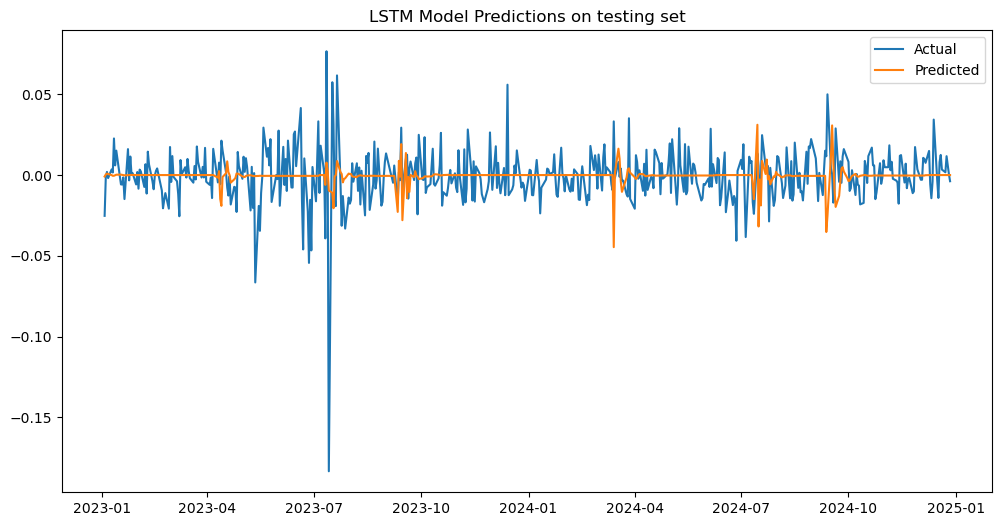

r2 score -0.0835


In [50]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).squeeze().cpu().numpy()

# Inverse transform predictions
# y_pred_test_rescaled = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
# y_test_rescaled = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

y_pred_test_rescaled = y_pred_test.reshape(-1, 1)
y_test_rescaled = y_test.cpu().numpy().reshape(-1, 1)

# Plot results

plt.figure(figsize=(12, 6))
plt.plot(data.index[-500:], y_test_rescaled, label='Actual')
plt.plot(data.index[-500:], y_pred_test_rescaled, label='Predicted')
plt.legend()
plt.title("LSTM Model Predictions on testing set")
plt.show()

print(f"r2 score {r2_score(y_test_rescaled, y_pred_test_rescaled):.4f}")

LSTM with weather

In [52]:
data = corn_data_with_weather.dropna()

def create_sequences(data, seq_length, features):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(data)
    
    features = list(data.columns)
    features.remove("Log_Return_Shift")
    
    feature_frame = data[features]
    target_series = data["Log_Return_Shift"]
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(feature_frame.iloc[i:i+seq_length])
        targets.append(target_series.iloc[i+seq_length])
    return np.array(sequences), np.array(targets)



SEQ_LENGTH = 60
X, y = create_sequences(data, SEQ_LENGTH, features)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X[:-500], dtype=torch.float32).to(device), torch.tensor(y[:-500], dtype=torch.float32).to(device)
X_test, y_test = torch.tensor(X[-500:], dtype=torch.float32).to(device), torch.tensor(y[-500:], dtype=torch.float32).to(device)

# print(X_train.shape[2])
# Reshape for LSTM (batch_size, seq_length, num_features)
X_train = X_train.view(-1, SEQ_LENGTH, X_train.shape[2])
X_test = X_test.view(-1, SEQ_LENGTH, X_train.shape[2])

# Create DataLoader
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

In [53]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # print(lstm_out)
        out = self.fc(lstm_out[:, -1, :])  # Take last output from LSTM
        # print(out)
        return out

# Initialize Model
model = LSTMModel(input_dim = X_train.shape[2]).to(device)


In [54]:
# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for batch_x, batch_y in train_loader:
        # if(torch.isnan(batch_x).any() or torch.isinf(batch_x).any() or torch.isnan(batch_y).any() or torch.isinf(batch_y).any()):
        #     print("hi")
        # print(torch.isnan(batch_x).any(), torch.isinf(batch_x).any())
        # print(torch.isnan(batch_y).any(), torch.isinf(batch_y).any())
        optimizer.zero_grad()
        y_pred = model(batch_x)
        # print(y_pred)
        loss = criterion(y_pred.squeeze(), batch_y)
        # print(y_pred.squeeze())
        # print(batch_y)
        # print(loss)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(train_loader):.6f}')

Epoch [10/100], Loss: 0.000269
Epoch [20/100], Loss: 0.000281
Epoch [30/100], Loss: 0.000268
Epoch [40/100], Loss: 0.000258
Epoch [50/100], Loss: 0.000256
Epoch [60/100], Loss: 0.000262
Epoch [70/100], Loss: 0.000255
Epoch [80/100], Loss: 0.000250
Epoch [90/100], Loss: 0.000243
Epoch [100/100], Loss: 0.000242


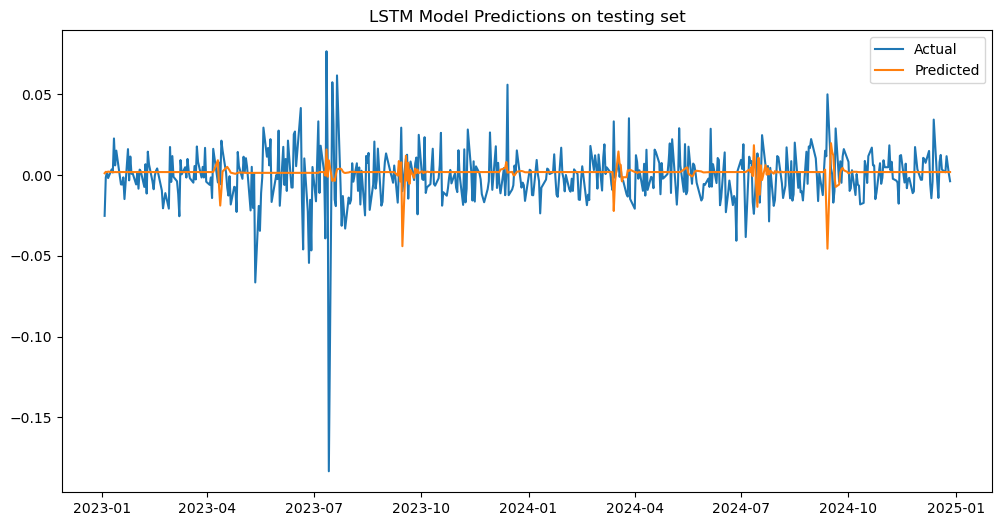

r2 score -0.1375


In [56]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).squeeze().cpu().numpy()

# Inverse transform predictions
# y_pred_test_rescaled = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
# y_test_rescaled = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

y_pred_test_rescaled = y_pred_test.reshape(-1, 1)
y_test_rescaled = y_test.cpu().numpy().reshape(-1, 1)

# Plot results

plt.figure(figsize=(12, 6))
plt.plot(data.index[-500:], y_test_rescaled, label='Actual')
plt.plot(data.index[-500:], y_pred_test_rescaled, label='Predicted')
plt.legend()
plt.title("LSTM Model Predictions on testing set")
plt.show()

print(f"r2 score {r2_score(y_test_rescaled, y_pred_test_rescaled):.4f}")

ARIMA with no weather

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

df_sugar = corn_data.dropna()

split_index = int(len(df_sugar)*0.8)
df_train = df_sugar[:split_index]['Log_Return_Shift']
df_test = df_sugar[split_index:]['Log_Return_Shift']

# Perform ADF test to check for stationarity
result = adfuller(df_sugar['Log_Return_Shift'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -26.651638216776522
p-value: 0.0


In [ ]:
# Fit a SARIMA model with seasonal order (p, d, q, s)
model = SARIMAX(df_train, order=(30, 1, 1), seasonal_order=(0, 1, 0, 12))  # (p, d, q, s)
model_fit = model.fit()

# Summary of the ARIMA model
print(model_fit.summary())


C:\Users\johng23\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\johng23\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\johng23\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA with weather

In [ ]:
# Make predictions (forecast) on the same dataset (for simplicity, we're using the same data for both)
forecast_steps = 40 # Number of periods you want to predict
forecast = model_fit.forecast(steps=forecast_steps)

# Visualizing the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_test[:forecast_steps], label='Historical Data')
plt.plot(df_test.index[:forecast_steps], forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import r2_score

days = [5,10,15,20,25,30]
for day in days:
    print(f'Days = {day}')
    print('Standard deviaiton of test data:', df_test[:day].std())
    print('Root MSE:', rmse(df_test[:day],forecast[:day]))
    print('R^2 score:', r2_score(df_test[:day],forecast[:day]))
    print()

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

df_sugar = corn_data_with_weather

split_index = int(len(df_sugar)*0.8)
df_train = df_sugar[:split_index]['Log_Return_Shift']
df_test = df_sugar[split_index:]['Log_Return_Shift']

# Perform ADF test to check for stationarity
result = adfuller(df_sugar['Log_Return_Shift'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -26.2129729135222
p-value: 0.0


In [62]:
# Fit a SARIMA model with seasonal order (p, d, q, s)
model = SARIMAX(df_train, order=(30, 1, 1), seasonal_order=(0, 1, 0, 12))  # (p, d, q, s)
model_fit = model.fit()

# Summary of the ARIMA model
print(model_fit.summary())


C:\Users\johng23\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\johng23\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\johng23\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\johng23\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converg

                                      SARIMAX Results                                       
Dep. Variable:                     Log_Return_Shift   No. Observations:                 2127
Model:             SARIMAX(30, 1, 1)x(0, 1, [], 12)   Log Likelihood                5345.175
Date:                              Mon, 21 Apr 2025   AIC                         -10626.349
Time:                                      00:29:13   BIC                         -10445.347
Sample:                                           0   HQIC                        -10560.075
                                             - 2127                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1817      0.075     -2.436      0.015      -0.328      -0.036
ar.L2         -0.18

C:\Users\johng23\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\johng23\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


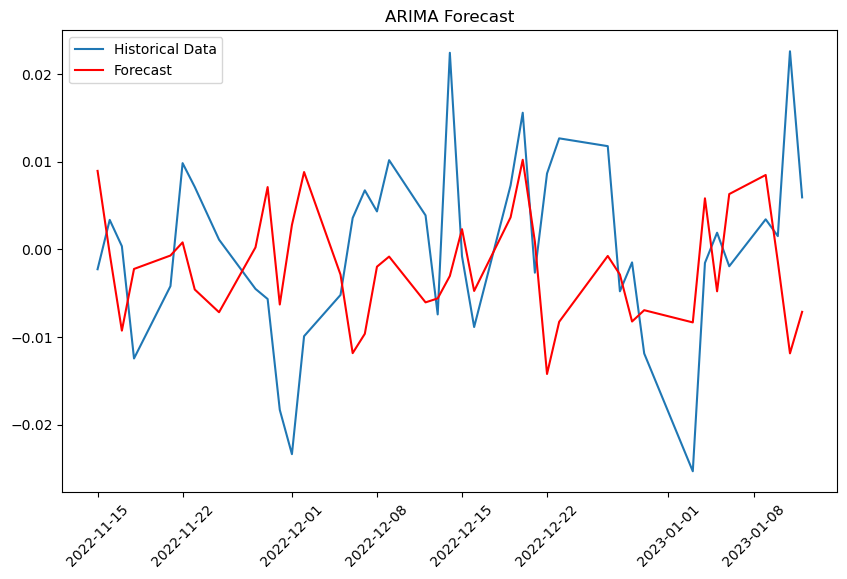

In [63]:
# Make predictions (forecast) on the same dataset (for simplicity, we're using the same data for both)
forecast_steps = 40 # Number of periods you want to predict
forecast = model_fit.forecast(steps=forecast_steps)

# Visualizing the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_test[:forecast_steps], label='Historical Data')
plt.plot(df_test.index[:forecast_steps], forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import r2_score

days = [5,10,15,20,25,30]
for day in days:
    print(f'Days = {day}')
    print('Standard deviaiton of test data:', df_test[:day].std())
    print('Root MSE:', rmse(df_test[:day],forecast[:day]))
    print('R^2 score:', r2_score(df_test[:day],forecast[:day]))
    print()

Days = 5
Standard deviaiton of test data: 0.0059781360995893006
Root MSE: 0.008365731744109924
R^2 score: -1.447858365169934

Days = 10
Standard deviaiton of test data: 0.006538894353817191
Root MSE: 0.009068917873376107
R^2 score: -1.1372719556998319

Days = 15
Standard deviaiton of test data: 0.009122434726409886
Root MSE: 0.012231133971763123
R^2 score: -0.9260836321557673

Days = 20
Standard deviaiton of test data: 0.0090468445922156
Root MSE: 0.011777795912177688
R^2 score: -0.784062988913591

Days = 25
Standard deviaiton of test data: 0.010252325983053034
Root MSE: 0.011816877302503047
R^2 score: -0.38385123661651765

Days = 30
Standard deviaiton of test data: 0.010029361100810085
Root MSE: 0.012416028258643609
R^2 score: -0.5854118697100761

